# Identifying Entities in Healthcare Data

##Workspace set up: Import and Install useful packages.

In [815]:
#!pip install pycrf
!pip install sklearn-crfsuite
!pip install pandas as pd
!pip install seaborn as sns

import spacy
import sklearn_crfsuite
from sklearn_crfsuite.metrics import flat_f1_score
from collections import Counter

model = spacy.load("en_core_web_sm")

import nltk #use of nltk is clear from the work as you scroll down
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as


ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SreekumarRadhakrishn\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\SreekumarRadhakrishn\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

##Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

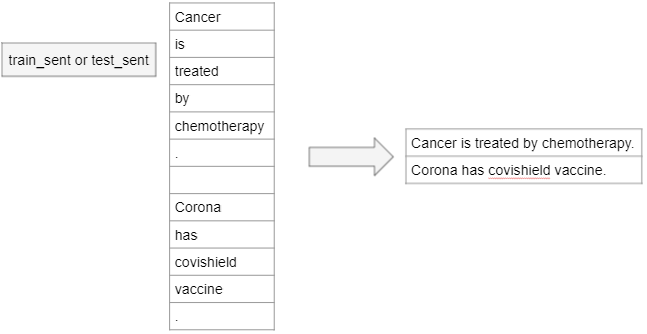

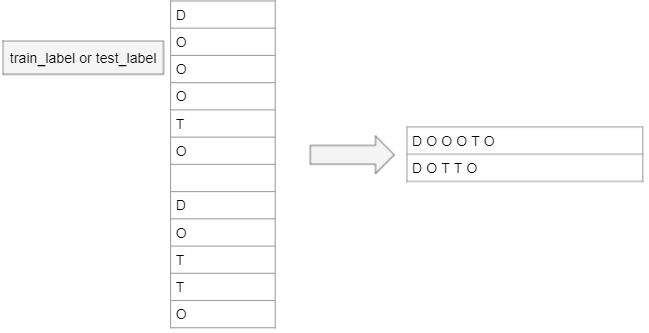

### Function to make and return sentences and labels from the training data set and testing data set

In [816]:
def make_sentences(file_name: str):
    with open (file_name, 'r') as f:
        train_sent = f.read()
    sents = train_sent.split("\n\n")  

    # removing blank sentences from the input text ie if there is an occurence of "\n\n" and there is no string after that
    for sent in sents:
        if sent == '':
            sents.remove('')
    
    i = 0
    sentences = []
    while i < len(sents):        
        sentence = " ".join(sents[i].split("\n"))
        sentences.append(sentence)
        i+=1
    
    return sentences


### Making list of training sentences using the function "make_sentences" and printing the first 5 sentences in training dataset

In [817]:
train_sentences = make_sentences("train_sent.txt")
train_sentences[:5]

['All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )',
 'The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )',
 'Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )',
 "The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )",
 "Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )"]

### Making list of test sentences using the function "make_sentences" and printing the first 5 sentences in test data set


In [818]:
test_sentences = make_sentences("test_sent.txt")
test_sentences[:5]

['Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )',
 'As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration',
 'The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period',
 'There was a significant correlation between the 2- , 3- , and 4-day mean temperature and AFI , with the 4-day mean being the most significant ( r = 0.31 , p & # 60 ; 0.001 )',
 'Fluctuations in ambient temperature are inversely correlated to changes in AFI']

### Count the number of sentences in the processed train and test dataset 

In [819]:
print("No. of training sentences:", len(train_sentences))
print("No. of test sentences:",len(test_sentences))

No. of training sentences: 2599
No. of test sentences: 1056


### Making list of labels for each corresponding sentence in training data and printing the first 5 label lists

In [820]:
train_labels = make_sentences("train_label.txt")
train_labels[:5]

['O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O O O O']

### Making list of labels for each corresponding sentence in test data and printing the first 5 label lists

In [821]:
test_labels = make_sentences("test_label.txt")
test_labels[:5]

['O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O']

### Count the number of lines of labels in the processed train and test dataset.

In [822]:
print("No. of training label sequences:",len(train_labels))
print("No. of testing label sequences:",len(test_labels))

No. of training label sequences: 2599
No. of testing label sequences: 1056


##Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [823]:
noun_propn_words = [] #initiating empty list of words which are nouns and propns
noun_propn_tags = [] #initiating empty list of nouns and propns tags
for sent in train_sentences:#for training data
    tokenized = model(sent) #tokenizing using spacy model
    for token in tokenized:
        if token.pos_ in (['NOUN', 'PROPN']):#checking for NOUN and PROPN tags
            noun_propn_words.append(token)#appending to words list
            noun_propn_tags.append(token.pos_)#appending to tags list
for sent in test_sentences:#for test data
    tokenized = model(sent)#tokenizing using spacy model
    for token in tokenized:
        if token.pos_ in (['NOUN', 'PROPN']):#checking for NOUN and PROPN tags
            noun_propn_words.append(token)#appending to words list
            noun_propn_tags.append(token.pos_)#appending to tags list
    

### Counting number of tokens or words identified as NOUN or PROPN

In [824]:
print(len(noun_propn_words))


24376


### Print the top 25 most common tokens with NOUN or PROPN PoS tags using Counter method from Collections library

In [825]:
super_sent = [token.text for token in noun_propn_words]
word_count = Counter(super_sent)#Counter method from Collections Library

for word, count in word_count.most_common(25):
    print(word, "--", count, "--", noun_propn_words[super_sent.index(word)].pos_)
    #PRints the word, number of occurences in the corpus(training data) and the corresponding PoS



patients -- 492 -- NOUN
treatment -- 281 -- NOUN
% -- 247 -- NOUN
cancer -- 200 -- NOUN
therapy -- 175 -- NOUN
study -- 154 -- NOUN
disease -- 142 -- NOUN
cell -- 140 -- NOUN
lung -- 116 -- NOUN
group -- 94 -- NOUN
chemotherapy -- 88 -- NOUN
gene -- 87 -- NOUN
effects -- 85 -- NOUN
results -- 79 -- NOUN
women -- 77 -- NOUN
use -- 74 -- NOUN
TO_SEE -- 74 -- PROPN
risk -- 71 -- NOUN
cases -- 71 -- NOUN
surgery -- 71 -- NOUN
analysis -- 70 -- NOUN
rate -- 67 -- NOUN
response -- 66 -- NOUN
survival -- 65 -- NOUN
children -- 64 -- NOUN


### From the above, we can get an understanding that the use case is mostly related to the disease cancer and its treatment

## Checking the best method to split the sentences. 
#### The number of items in each label sequence and the number of words in the corresponding sentence should match. That means the splitting of the sentences should be in such a way that the number of labels should match. Different splitting methods are used to check the best option.
- 1. using string split() method which splits the sentence at white spaces.
- 2. using spacy to split the sentence into words based on spacy's logic.


In [826]:
# USing split() method
x = 0
for i in range(len(train_sentences)):
    if (len((train_sentences[i].split())) != len(train_labels[i].split())):
        print("Not Matching:\n", i, "\n", len((train_sentences[i].split()), "\n",  len(train_labels[i].split())))
        x+=1
print("No. of mismatches:", x)

No. of mismatches: 0


### It can be seen from the above that the number of words using split() method applied to each sentence is matching the number of labels in the label sequence corresponding to that sentence

In [827]:
x = 0
for i in range(len(train_sentences)):
    if (len(model(train_sentences[i])) != len(train_labels[i].split())):
        #print("Not Matching:\n", i, "\n", len(model(train_sentences[i])), "\n",  len(train_labels[i].split()))
        x+=1
print("No. of mismatches: ", x)

No. of mismatches:  796


### It can be seen from the above that the number of words using spacy's model applied to each sentence is NOT matching with the number of labels in the label sequence corresponding to that sentence. This could pose a potential problem in training. 

For example, 'maternal-fetal' is being considered as three separate tokens 'maternal', '-', 'fetal' when using spacy, where as in labels, it is just a single token. In the same manner 'ca2+' is considered as 'ca2' and '+' when using spacy, but considered as a single token in labels. Then there is the case of two punctuation symbols occuring together, which spacy splits into two where as we don't want that as per the labels. Tried tweaking(like removing hyphenation etc) the spacy model but there are numerous other edge cases. Therefore spacy is ruled ot for CRF training, in obtaining features and PoS tags.

 The way may be to use split() method, but we wont get PoS tags and NLP related attributes from split(). We have to use an NLP method. 


### Alternative is to use nltk methods. 
Therefore trying out with nltk models. Here, each split token from a sentence using split() method can be passed on to NLTK model to get the PoS tag. nltk wont further split cases like 'maternal-fetal' and 'ca2+'. The number of tokens will be same when using the split() method and can match with the sequence of labels for each corresponding sentence

### Using nltk methods

In [828]:
x = 0
labels_cache = []
for i in range(len(train_sentences)):
    for word in train_sentences[i].split():
        labels_cache.append(nltk.pos_tag([word])[0][1])        
    if (len(labels_cache) != len(train_labels[i].split())):
        x+=1
    print(len(labels_cache), len(train_labels[i].split()))    
    labels_cache = []
print("\n\nNo. of mismatches=", x)

45 45
25 25
15 15
38 38
22 22
24 24
19 19
14 14
40 40
12 12
22 22
17 17
31 31
22 22
22 22
13 13
8 8
17 17
26 26
27 27
28 28
34 34
18 18
25 25
16 16
7 7
15 15
29 29
30 30
13 13
9 9
15 15
15 15
29 29
10 10
10 10
9 9
9 9
13 13
52 52
40 40
41 41
44 44
33 33
29 29
17 17
33 33
9 9
51 51
11 11
12 12
34 34
12 12
75 75
26 26
19 19
8 8
26 26
46 46
24 24
29 29
17 17
26 26
16 16
27 27
21 21
12 12
48 48
23 23
17 17
62 62
38 38
48 48
51 51
14 14
29 29
19 19
32 32
22 22
15 15
25 25
30 30
15 15
13 13
9 9
32 32
31 31
25 25
27 27
32 32
31 31
50 50
35 35
13 13
30 30
27 27
22 22
26 26
51 51
12 12
27 27
12 12
28 28
16 16
18 18
29 29
18 18
45 45
27 27
10 10
21 21
19 19
19 19
12 12
20 20
19 19
22 22
18 18
15 15
16 16
17 17
7 7
27 27
10 10
72 72
31 31
60 60
22 22
26 26
22 22
38 38
24 24
24 24
19 19
19 19
24 24
18 18
8 8
12 12
22 22
7 7
22 22
23 23
46 46
51 51
27 27
38 38
23 23
46 46
33 33
34 34
33 33
29 29
25 25
6 6
16 16
22 22
36 36
9 9
36 36
15 15
18 18
8 8
33 33
58 58
41 41
16 16
25 25
28 28
7 7
32 32
23 2

### It can be seen from the above that the number of tokens is same when using split() method together with nltk. Therefore spacy is ruled our of feature extraction and using nltk instead

## Defining features for CRF





In [829]:
# defining the features to get the feature value for one word.

def feature_definition_word_only_prev_word(words_split, index):
    word = words_split[index]
    features = [
        "word.lower="+word.lower(),
        "word.PoS="+nltk.pos_tag([word])[0][1]
        ]
    
    if(index > 0 and index < (len(words_split)-1)):
        prev_word = words_split[index-1]
        #next_word = words_split[index+1]
        features.extend([
            'prev_word.lower=' + prev_word.lower(), 
            "prev_word.PoS="+nltk.pos_tag([prev_word])[0][1]           
        ])
        
    elif index == 0:
        features.append('BEG')

    if(index == len(words_split)-1):
        features.append('END')
        
    return features


In [830]:
# define the features to get the feature value for one word. 
#Previous word and the next word are used since there is an improvement in f1 score when using both previous and next words

def feature_definition_word(words_split, index):
    word = words_split[index]
    features = [
        "word.lower="+word.lower(),
        "word.PoS="+nltk.pos_tag([word])[0][1]
        ]
    
    if(index > 0 and index < (len(words_split)-1)):
        prev_word = words_split[index-1]
        next_word = words_split[index+1]
        features.extend([
            'prev_word.lower=' + prev_word.lower(), 
            "prev_word.PoS="+nltk.pos_tag([prev_word])[0][1],
            'next_word.lower='+ next_word.lower(),
            "next_word.PoS="+nltk.pos_tag([next_word])[0][1]           
        ])
        
    elif index == 0:
        features.append('BEG')

    if(index == len(words_split)-1):
        features.append('END')
        
    return features


## Getting the features

### Write a code/function to get the features for a sentence

In [831]:
# code to get features for a sentence.This was a trial to consider two adjacent punctuation marks together without splitting. 
# Not used in the final code
def feature_definition_sentence_old(sentence):
    sentence = model(sentence)
    final_words = []
    previous_word = None
    for word in sentence:
        if word.pos_ == 'PUNCT' and previous_word and word.text == previous_word.text:
            continue
        else:
            final_words.append(word)
        previous_word = word
    words_split = [word.text for word in final_words]
    words_spacy = list(sentence)
    #words_split = sentence.split()
    return [feature_definition_word(words_spacy, words_split, index) for index in range(len(words_split))]

In [832]:
# code to get features for a sentence. Just splitting is now required since nltk and split() will do the work
def feature_definition_sentence(sentence):
    words_split = sentence.split()
    
    return [feature_definition_word(words_split, index) for index in range(len(words_split))]

### Write a code/function to get the labels of a sentence

In [833]:
# code to get the labels for a sentence.
def get_labels_sentence(label):
    return label.split()

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

#### Building model with both previous word and next word as features, together with PoS

In [834]:
X_train = [feature_definition_sentence(sentence) for sentence in train_sentences]
X_test = [feature_definition_sentence(sentence) for sentence in test_sentences]

In [835]:
len(X_train)#Checking the length of training dataset

2599

### Define the labels as the target variable for test and the train dataset

In [836]:
y_train = [get_labels_sentence(label) for label in train_labels]
y_test = [get_labels_sentence(label) for label in test_labels]

#### Building model with only the previous word  as features together with PoS, for comparison of F1-Score

In [837]:
# code to get features for a sentence. Just splitting is now required since nltk and split() will do the work
def feature_definition_sentence_prev(sentence):
    words_split = sentence.split()
    
    return [feature_definition_word_only_prev_word(words_split, index) for index in range(len(words_split))]

In [838]:
X_train_prev = [feature_definition_sentence_prev(sentence) for sentence in train_sentences]
X_test_prev = [feature_definition_sentence_prev(sentence) for sentence in test_sentences]

### Checking if the number of words in each sentence is matching the number of labels in the corresponding label sequence after feature definition and extraction.

In [839]:
x = 0
for i in range(len(train_sentences)):
    if (len(feature_definition_sentence(train_sentences[i])) != len(get_labels_sentence(train_labels[i]))):
        print("Not Matching:\n", i, "\n", len(feature_definition_sentence(train_sentences[i])), "\n",  len(get_labels_sentence(train_labels[i])))
        x+=1
print("No. of mismatches: ", x)

No. of mismatches:  0


### Checking random sentence split into words using split() and tokenize method of nltk. 

In [840]:
print(train_sentences[2493].split())
tokens = word_tokenize(train_sentences[2493])
print(word_tokenize(train_sentences[2493]))

['Standard', 'versus', 'high-dose', 'therapy', 'in', '10+', 'breast', 'cancer']
['Standard', 'versus', 'high-dose', 'therapy', 'in', '10+', 'breast', 'cancer']


In [841]:
print(nltk.pos_tag(tokens))

[('Standard', 'NNP'), ('versus', 'VBZ'), ('high-dose', 'JJ'), ('therapy', 'NN'), ('in', 'IN'), ('10+', 'CD'), ('breast', 'NN'), ('cancer', 'NN')]


In [842]:
nltk.pos_tag(["my-name"])[0][1]

'NN'

In [843]:
count = 0
for i in train_sentences:
    split_len = len(i.split())
    nltk_len = len(word_tokenize(i))
    if split_len != nltk_len:
        print(split_len, "--",  nltk_len, "--", i)
        count+=1
print("No. of mismatches(nltk tokenizer)= ", count)

32 -- 38 -- RESULTS : The HLA effect is due to the class II DR2 haplotype , DRB1*1501-DQA1*0102-DRB1*0602 ; contributions to MS susceptibility from additional DRB1-DQB1 alleles or other HLA region loci were not observed
55 -- 56 -- Lactate values obtained by continuous catheter operation ex vivo correlate well with those obtained by BIOSEN Med L. First subcutaneous implantation ( dog ) underlines the characteristics obtained ex vivo : after 30 min hydration the lactate catheter follows the lactate concentration measured ex vivo with samples from the leg vein by BIOSEN Med L.
12 -- 13 -- Oviposition and its regulation in the polygynous society of Polistes gallicus L.
14 -- 15 -- A fine structural analysis of the epidermis of the earthworm , Lumbricus terrestris L.
No. of mismatches(nltk tokenizer)=  4


### From the above, it can be seen that nltk tokenizer method has still some mismatches though substantially less. But still not perfect.

In [844]:
count = 0
for i in train_sentences:
    split_len = len(i.split())
    spacy_len = len(model(i))
    if split_len != spacy_len:
        print(split_len, "--",  spacy_len, "--", i)
        count+=1
print("\n\n\nNo. of mismatches (spacy)=", count)

38 -- 42 -- The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )
22 -- 23 -- Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )
22 -- 26 -- A 2- , 3- , and 4-day mean temperature prior to the test date was compared to AFI using a Spearman-rank Correlation
17 -- 19 -- This relationship should be taken into account when interpreting the AFI as a measure of fetal well-being
31 -- 33 -- The study population included 84 women with gestational diabetes , ascertained by universal screening of all women attending the antenatal clinic of the Hadassah Medical Center , over a 2-year period
22 -- 23 -- The 60 women ( 71 % ) , who initiated treatment before 34 completed weeks , composed the `` early '' group
22 -- 23 -- The 24 women ( 29 % ) , who initiated treatment after the 34th week , composed t

### from the above, it can be seen that there are 796 mismatches and spacy tokenizer is out of question, proved again

## Build the CRF Model

### various algorithms are used for CRF, the f1 score are compared and the best one is chosen

In [877]:
# Build the CRF model with algorithm 'pa'
crf_pa = sklearn_crfsuite.CRF(max_iterations=100, algorithm='pa')
crf_pa.fit(X_train, y_train)
y_pred = crf_pa.predict(X_test)
f1_pa = flat_f1_score(y_test, y_pred, average='weighted')
f1_pa

0.9185340918118996

In [878]:
# Build the CRF model with algorithm 'ap'
crf = sklearn_crfsuite.CRF(max_iterations=100, algorithm='ap')
crf.fit(X_train, y_train)
y_pred = crf.predict(X_test)
f1_ap = flat_f1_score(y_test, y_pred, average='weighted')
f1_ap

0.9182284625896802

In [879]:
# Build the CRF model with algorithm 'lbfgs'
crf = sklearn_crfsuite.CRF(max_iterations=100, algorithm='lbfgs')
crf.fit(X_train, y_train)
y_pred = crf.predict(X_test)
f1_lbfgs = flat_f1_score(y_test, y_pred, average='weighted')
f1_lbfgs

0.903275052568046

In [880]:
# Build the CRF model with algorithm 'l2sgd'
crf = sklearn_crfsuite.CRF(max_iterations=100, algorithm='l2sgd')
crf.fit(X_train, y_train)
y_pred = crf.predict(X_test)
f1_l2sgd = flat_f1_score(y_test, y_pred, average='weighted')
f1_l2sgd

0.9041202880091156

In [881]:
# Build the CRF model with algorithm 'arow'
crf = sklearn_crfsuite.CRF(max_iterations=100, algorithm='arow')
crf.fit(X_train, y_train)
y_pred = crf.predict(X_test)
f1_arow = flat_f1_score(y_test, y_pred, average='weighted')
f1_arow

0.9027557948801219

<Axes: xlabel='Algorithms', ylabel='F1-Score'>

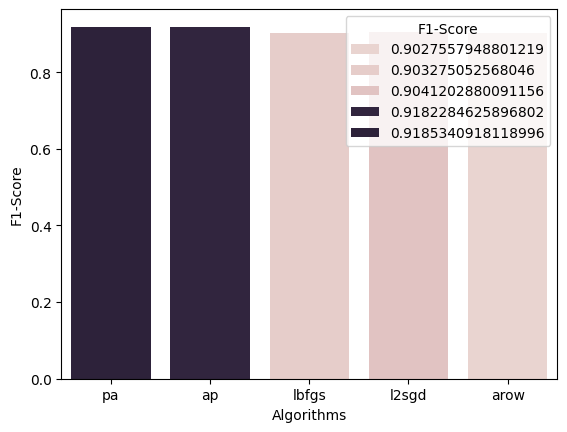

In [883]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame({'Algorithms': ['pa', 'ap', 'lbfgs', 'l2sgd','arow'], 'F1-Score': [f1_pa, f1_ap, f1_lbfgs, f1_l2sgd, f1_arow]})
sns.barplot(data=df, x='Algorithms', y='F1-Score', hue='F1-Score')

### It can be seen from the above that algorithm 'pa' has the maximum f1-score of 0.9185

### Checking the F1-Score with only previous word as the feature together with PoS. No next word is used, just for comparison. Informatively, the final model has next word also in the list of features, therefore giving more accuracy

In [884]:
# Build the CRF model with algorithm 'pa'
crf_prev = sklearn_crfsuite.CRF(max_iterations=100, algorithm='pa')
crf_prev.fit(X_train_prev, y_train)
y_pred_prev = crf_prev.predict(X_test_prev)
flat_f1_score(y_test, y_pred_prev, average='weighted')

0.9158301781030854

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.
### Using 'pa' algorithm found to be giving more accuracy

In [885]:
y_pred = crf_pa.predict(X_test)


### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [886]:
flat_f1_score(y_test, y_pred, average='weighted')

0.9185340918118996

### Informatively, from above, there is marginal increase in the F1-Score when using both previous word and next word as features together with PoS

##Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

image.png

Checking format of y_pred

In [854]:
print(y_pred[1])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


### Making a list of diseases from test_sentences and predicted labels y_pred for test sentences

In [855]:
diseases = []

for sentence, label in zip(test_sentences, y_pred):
    words = sentence.split()
    disease_cache = ""

    for word, label in zip(words, label):
        if label == 'D':
            disease_cache += word + " "
        else:
            if disease_cache:
                diseases.append(disease_cache.strip().lower())
                disease_cache = ""
    
    if disease_cache:
        if disease_cache not in diseases:
            diseases.append(disease_cache.strip().lower())

diseases = list(set(diseases))# making a set and back to list to get rid of duplicates

### diseases list from test sentences

In [856]:
#Diseases list from test_sentences
diseases

['duodenal ulcer',
 'colon tumors',
 'sclc',
 'limited stage small cell lung cancer',
 'hairy cell leukemia',
 'pneumocystis carinii pneumonia',
 'revascularizations',
 'colonic polyps',
 'pulmonary aspergilloma',
 'restenosis',
 'cerebral injuries',
 'gastrointestinal tumours',
 'b16 melanoma',
 'advanced esophageal cancer',
 'acute respiratory distress syndrome',
 'reduced metastatic load',
 'hemiretinal vein occlusion',
 'preeclampsia',
 'ventricular tachycardia',
 'renovascular hypertension',
 'partial seizures',
 "oral crohn 's disease",
 'unstable angina',
 'metastatic colorectal cancer',
 'attention deficit hyperactivity disorder',
 'left ventricular anterior wall',
 'sclc , limited disease',
 'fetalis',
 'depression',
 'ectopic pregnancy',
 'contemporary asthma management',
 'colds',
 'mediastinal teratomas',
 'rheumatic',
 'large lesions',
 'atrial fibrillation',
 'chronic hepatitis c',
 'macular degeneration',
 'pathologic stage i non-small cell lung cancer',
 'congenital bil

### Making a dictionary of treatments for each disease from the test_sentence. Treatments are also from test_sentences as instructed.
key is the disease name and value is the treatment

In [857]:
treatments = {}
for disease in diseases:
    for i, sentence in enumerate(test_sentences):
        if disease in sentence.split():
            sentence_cache = sentence.split()
            labels_cache = test_labels[i].split()
            treatment_cache = []
            for j, label in enumerate(labels_cache):
                if label == 'T':
                    treatment_cache.append(sentence_cache[j].strip())            
            if disease in treatments:
                treatments[disease].extend(treatment_cache)
            else:
                treatments[disease] = treatment_cache

for disease, treatment_list in treatments.items():
    treatments[disease] = list(set(treatment_list))


In [858]:
for key, value in treatments.items():
    print(key)

sclc
revascularizations
restenosis
preeclampsia
fetalis
depression
colds
rheumatic
amyloidosis
pertussis
cancer
retinoblastoma
melanoma
migraine
perinatal
sore
carcinoma
tumors
hyperammonemia
tumor
hypothyroidism
psoriasis
pneumonia
asthma
endometriosis
cancers
stroke
hypertension
deafness
hyponatremia
retinopathy
neutropenia
encephalopathy
splenomegaly
diabetes
macrosomic
arthritis
influenza
availability
phaeochromocytoma
epilepsy
infection
nsclc
malaria
glaucoma
microcephaly
bos


### Predict the treatment for the disease name: 'retinoblastoma'. 

In [859]:
treatments['retinoblastoma']

[]

### From the above, it can be seen that the model is working fine and predicting from test data for the labels in the training data.

### Predict the treatment for the disease name: "hereditary retinoblastoma"


### <span style="color:red;">Please scroll down to the last for explanation.</span>

In [860]:
try:
    treatments['hereditary retinoblastoma']
except KeyError as e:
    print("Couldn't find the disease in the dictionary", KeyError, e)

Couldn't find the disease in the dictionary <class 'KeyError'> 'hereditary retinoblastoma'


### Making a dictionary of treatment from training dataset to see if there is any improvement

In [861]:
treatments = {}
for disease in diseases:
    for i, sentence in enumerate(train_sentences):
        if disease in sentence.split():
            sentence_cache = sentence.split()
            labels_cache = train_labels[i].split()
            treatment_cache = []
            for j, label in enumerate(labels_cache):
                if label == 'T':
                    treatment_cache.append(sentence_cache[j].strip())            
            if disease in treatments:
                treatments[disease].extend(treatment_cache)
            else:
                treatments[disease] = treatment_cache

for disease, treatment_list in treatments.items():
    treatments[disease] = list(set(treatment_list))

In [862]:
try:
    treatments['hereditary retinoblastoma']
except KeyError as e:
    print("Couldn't find the disease in the dictionary", KeyError, e)


Couldn't find the disease in the dictionary <class 'KeyError'> 'hereditary retinoblastoma'


### It can be seen that hereditary retinoblastoma is not in the list of diseases extracted from the test_sentences using the model.
### Even tried with extracting treatments from both training_sentences and test_sentences. Both couldn't identify "hereditary retinoblastoma"
### Checking for the problems.
### <span style="color:red;">Please scroll down to the last for explanation.</span>

In [863]:
for i in range(len(test_sentences)):
    if "retinoblastoma" in test_sentences[i]:
        print(test_sentences[i].split(), "\n", test_labels[i].split())
        print(i)
        print(len(test_sentences[i].split()),"\n", len(test_labels[i].split()))
       

['<', 'TO_SEE', '>', 'CONTEXT', ':', 'There', 'is', 'a', 'substantial', 'risk', 'of', 'a', 'second', 'cancer', 'for', 'persons', 'with', 'hereditary', 'retinoblastoma', ',', 'which', 'is', 'enhanced', 'by', 'radiotherapy'] 
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
46
25 
 25


#### It can be seen from the above that for test_sentences, test_labels for disease are not present for the word 'hereditary'. It is tagged as 'O'. Even 'retinoblastoma' is tagged as 'O' in the test sentence list

### Predicting the labels for same test sentence using the model

In [864]:
labels = crf_pa.predict([feature_definition_sentence(test_sentences[46])])
print(test_sentences[46])
print(labels)

< TO_SEE > CONTEXT : There is a substantial risk of a second cancer for persons with hereditary retinoblastoma , which is enhanced by radiotherapy
[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'D', 'O', 'O', 'O', 'O', 'D', 'O', 'O', 'O', 'O', 'O', 'T']]


### But, the model was able to predict the correct labels 'D' for "retinoblastoma", even for "cancer". This is a good sign. May be the fi-score will improve, if the test_data sentences are labelled correctly

### Checking the training dataset sentences for "heredtiray retinoblasotma"

In [865]:
#Printing indexes of the sentences where the word "retinoblastom" appears
index = []
for i in range(len(train_sentences)):
    #labels = crf.predict([feature_definition_sentence(train_sentences[i])])
    if 'retinoblastoma' in train_sentences[i]:
        print(i)
        index.append(i)

88
89
90
91
92
93
95
1169
2464


In [866]:
for i in index:
    print(train_sentences[i], "\n", train_labels[i])

< TO_SEE > OBJECTIVE : To examine long-term risk of new primary cancers in survivors of childhood retinoblastoma and quantify the role of radiotherapy in sarcoma development 
 O O O O O O O O O O O O O O O O O O O O O O O O O O O
DESIGN : Cohort incidence study of patients with retinoblastoma followed for a median of 20 years , and nested case-control study of a radiation dose-response relationship for bone and soft tissue sarcomas 
 O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O
SETTING/PARTICIPANTS : A total of 1604 patients with retinoblastoma who survived at least 1 year after diagnosis , identified from hospital records in Massachusetts and New York during 1914 to 1984 
 O O O O O O O O D O O O O O O O O O O O O O O O O O O O O O O
RESULTS : Incidence of subsequent cancers was statistically significantly elevated only in the 961 patients with hereditary retinoblastoma , in whom 190 cancers were diagnosed , vs 6.3 expected in the general population ( relative risk 

### From the above it can be seen that the training labels are 'O' for the word 'hereditary'. If the labels are wrongly assigned, the model will not be getting trained in the right manner.

### Since the word "retinoblastoma" is marked correctly as a disease in the training dataset, let us check the treatment for that disease

In [867]:
treatments['retinoblastoma']

['treatment', 'radiation', 'gene', 'therapy']

### <span style="color:red;">It can be seen that the treatments are correctly identified by the model from the test_sentences for "retinoblastoma". This is due to the fact that this word is correctly labelled in the training dataset. <br>Since "hereditary" is not marked as a disease and not marked as label 'D' in the training dataset, it wont be recognized as a disease name. <br><br></span>
## <span style="color:red;">Therefore concluded that the model has done it's job based on the training data provided to it.</span>